# Выбор локации для скважины

## Описание проекта

Предоставлены данные добывающей компании «ГлавРосГосНефть». Необходимо принять решение о том, где бурить новую скважину.

В дыннх содержатся результаты проб нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой Bootstrap.

**Условия:**
* Для обучения модели применять только линейную регрессию (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода.
* Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них необходимо выбрать регион с наибольшей средней прибылью.
* **Данные синтетические:** детали контрактов и характеристики месторождений не разглашаются.

## Описание данных

**Данные по каждому из трех регионов:**
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

## План работы

* Загрузка изучение и подготовка данных
* Построение модели для предсказания объема запасов в новых скважинах
* Выбор скважины с самыми высокими оценками
* Определение региона с максимальной суммарной прибылью отобранных скважин
* Итоговые выводы по проекту

## Импорты и настройки

In [1]:
# Импорты
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline  import Pipeline

In [2]:
# Настройки
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Зафиксируем random state для всего проекта
np.random.seed(777)

## Загрузка изучение и подготовка данных

### Загрузка данных

In [4]:
# Загрузка
try:
    original_df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    original_df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    original_df_3 = pd.read_csv('/datasets/geo_data_2.csv')
    display('Данные из Практикума загружены.')
except:
    original_df_1 = pd.read_csv('datasets/geo_data_0.csv')
    original_df_2 = pd.read_csv('datasets/geo_data_1.csv')
    original_df_3 = pd.read_csv('datasets/geo_data_2.csv')
    display('Локальные данные загружены.')

# Изучим размеры
original_df_1.shape, original_df_2.shape, original_df_3.shape

'Локальные данные загружены.'

((100000, 5), (100000, 5), (100000, 5))

In [5]:
# Взглянем на датасеты
for i, df in enumerate([original_df_1, original_df_2, original_df_3]):
    display(f'Region {i + 1}:')
    display(df.head())
    display(df.tail())
    display(df.info())

'Region 1:'

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,id,f0,f1,f2,product
99995,DLsed,0.97,0.37,6.08,110.74
99996,QKivN,1.39,-0.38,1.27,122.35
99997,3rnvd,1.03,0.02,-1.35,64.38
99998,7kl59,1.00,-0.53,1.58,74.04
99999,1CWhH,1.76,-0.27,5.72,149.63


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Region 2:'

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,id,f0,f1,f2,product
99995,QywKC,9.54,-6.88,2.00,53.91
99996,ptvty,-10.16,-12.56,5.01,137.95
99997,09gWa,-7.38,-3.08,5.00,137.95
99998,rqwUm,0.67,-6.15,1.00,30.13
99999,relB0,-3.43,-7.79,-0.00,3.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'Region 3:'

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


,id,f0,f1,f2,product
99995,4GxBu,-1.78,1.13,6.26,172.33
99996,YKFjq,-1.26,-0.89,2.52,138.75
99997,tKPY3,-1.20,-2.96,5.22,157.08
99998,nmxp2,-2.42,2.42,-5.55,51.80
99999,V9kWn,-2.55,-2.03,6.09,102.78


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### Изучение данных

In [6]:
# Для удобства создадим единый рабочий датафрейм с добавлением столбца `region`
df = pd.concat([pd.concat([original_df_1, pd.Series([1] * original_df_1.shape[0], name='region')], axis='columns'),
                pd.concat([original_df_2, pd.Series([2] * original_df_2.shape[0], name='region')], axis='columns'),
                pd.concat([original_df_3, pd.Series([3] * original_df_3.shape[0], name='region')], axis='columns')],
               axis='index')
df.shape

(300000, 6)

In [7]:
# Посмотрим на прямые дубликаты
df.duplicated().sum()

0

In [8]:
# Посмотрим на дубликаты по id
display(f'Дубликаты по id среди всех регионов: {df["id"].duplicated().sum()}')
display(f'Дубликаты по id в 1 регионе: {df["id"][df["region"] == 1].duplicated().sum()}')
display(f'Дубликаты по id во 2 регионе: {df["id"][df["region"] == 2].duplicated().sum()}')
display(f'Дубликаты по id в 3 регионе: {df["id"][df["region"] == 3].duplicated().sum()}')

'Дубликаты по id среди всех регионов: 49'

'Дубликаты по id в 1 регионе: 10'

'Дубликаты по id во 2 регионе: 4'

'Дубликаты по id в 3 регионе: 4'

In [9]:
# Дубли по id в 1 регионе
df[df['region']==1][df[df['region']==1]['id'].duplicated(keep=False)].sort_values('id').head(20)

,id,f0,f1,f2,product,region
66136,74z30,1.08,-0.31,6.99,127.64,1
64022,74z30,0.74,0.46,5.15,140.77,1
51970,A5aEY,-0.18,0.94,-2.09,33.02,1
3389,A5aEY,-0.04,0.16,0.21,89.25,1
69163,AGS9W,-0.93,0.12,-3.66,19.23,1
42529,AGS9W,1.45,-0.48,0.68,126.37,1
931,HZww2,0.76,0.37,1.86,30.68,1
7530,HZww2,1.06,-0.37,10.43,158.83,1
63593,QcMuo,0.64,-0.47,0.86,64.58,1
1949,QcMuo,0.51,-0.32,-2.22,75.50,1


In [10]:
# Дубли по id во 2 регионе
df[df['region']==2][df[df['region']==2]['id'].duplicated(keep=False)].sort_values('id').head(20)

,id,f0,f1,f2,product,region
5849,5ltQ6,-3.44,-12.30,2.00,57.09,2
84461,5ltQ6,18.21,2.19,3.99,107.81,2
1305,LHZR0,11.17,-1.95,3.00,80.86,2
41906,LHZR0,-8.99,-4.29,2.01,57.09,2
2721,bfPNe,-9.49,-5.46,4.01,110.99,2
82178,bfPNe,-6.20,-4.82,3.00,84.04,2
47591,wt4Uk,-9.09,-8.11,-0.00,3.18,2
82873,wt4Uk,10.26,-9.38,4.99,134.77,2


In [11]:
# Дубли по id в 3 регионе
df[df['region']==3][df[df['region']==3]['id'].duplicated(keep=False)].sort_values('id').head(20)

,id,f0,f1,f2,product,region
45404,KUPhW,0.23,-1.70,4.99,11.72,3
55967,KUPhW,1.21,3.18,5.54,132.83,3
11449,VF7Jo,2.12,-0.86,5.75,181.72,3
49564,VF7Jo,-0.88,0.56,0.72,136.23,3
44378,Vcm5J,-1.23,-2.44,1.22,137.97,3
95090,Vcm5J,2.59,1.99,2.48,92.33,3
28039,xCHr8,1.63,0.37,-2.38,6.12,3
43233,xCHr8,-0.85,2.10,5.60,184.39,3


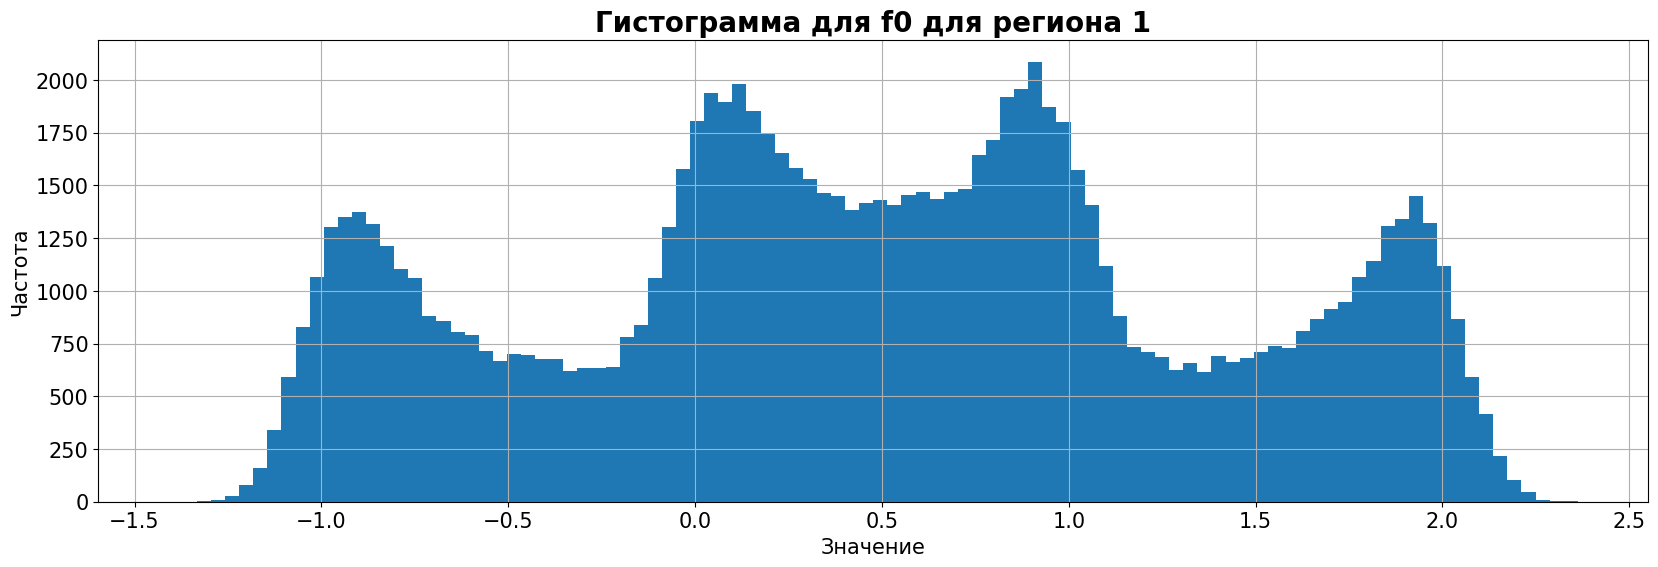

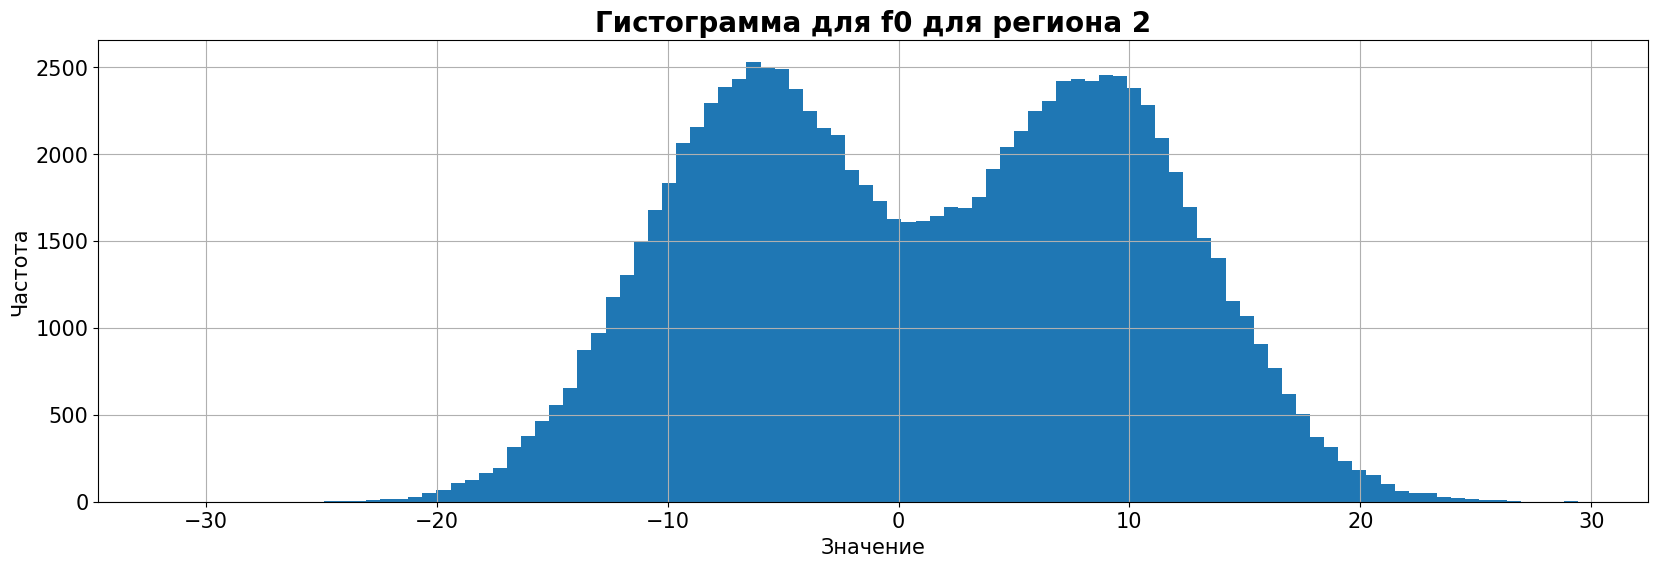

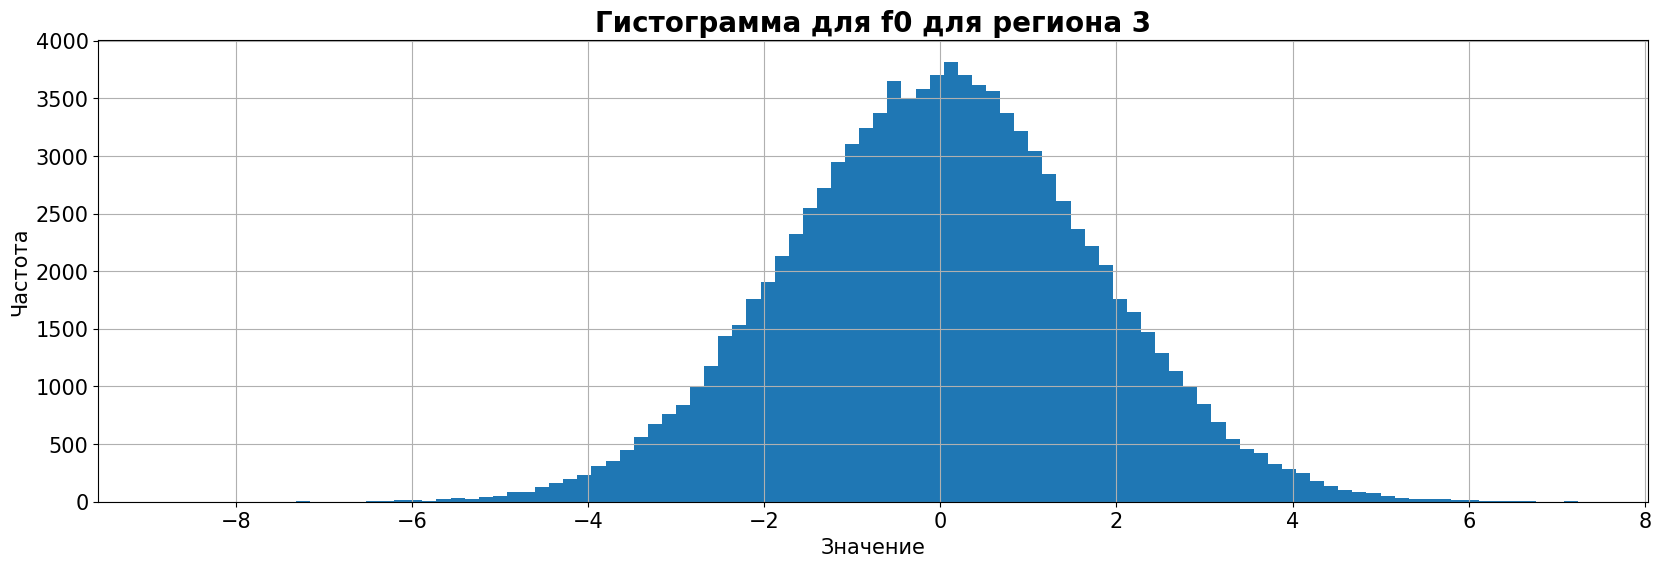

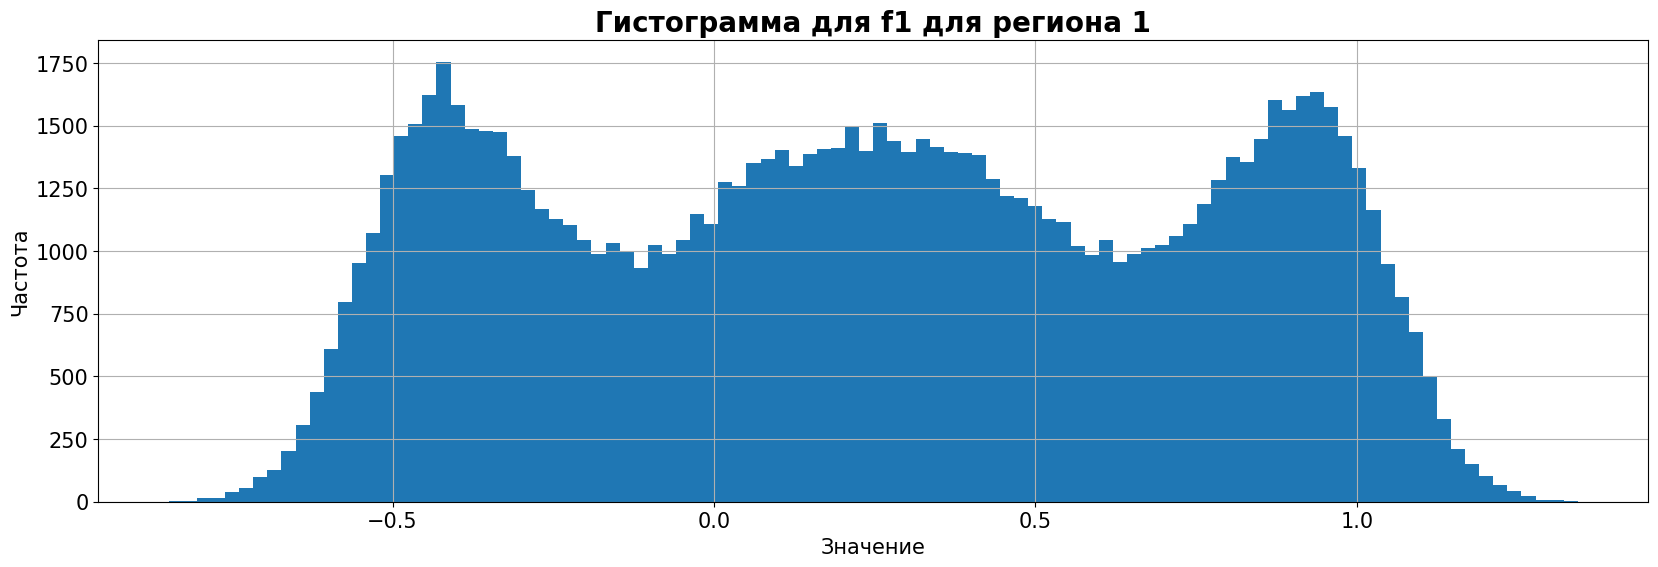

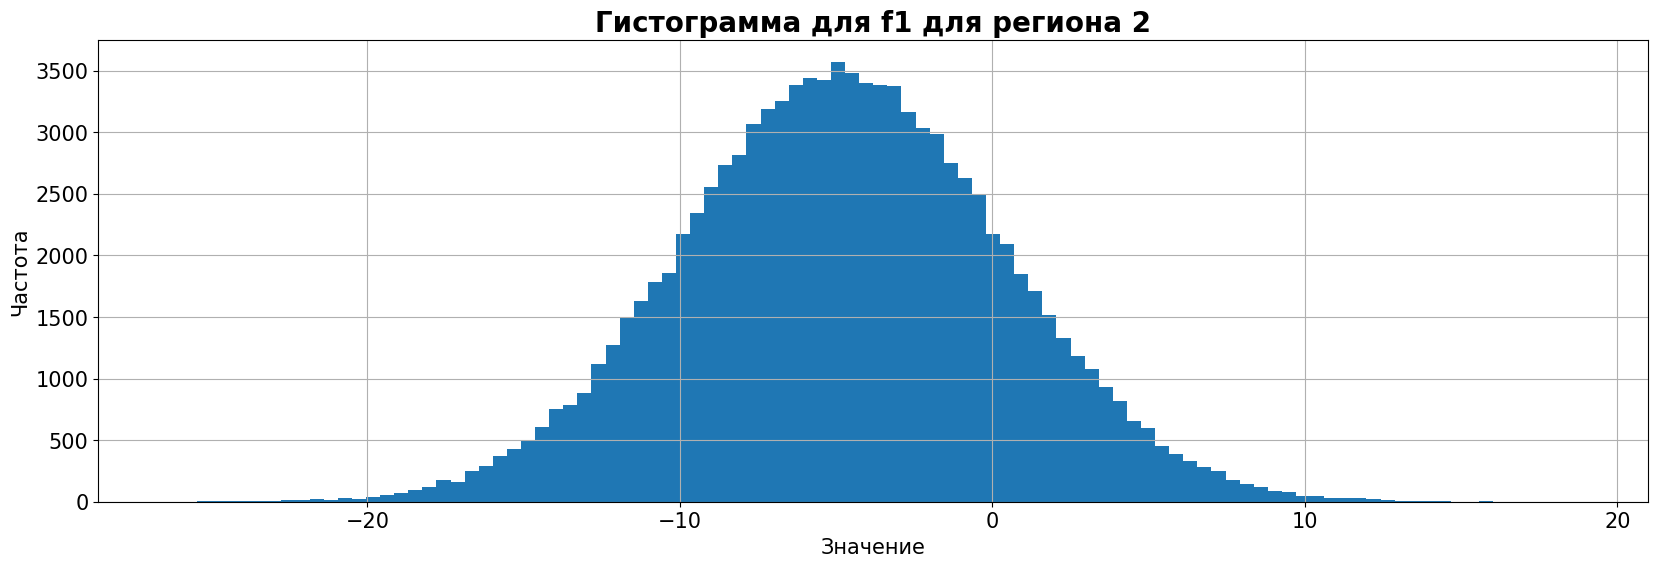

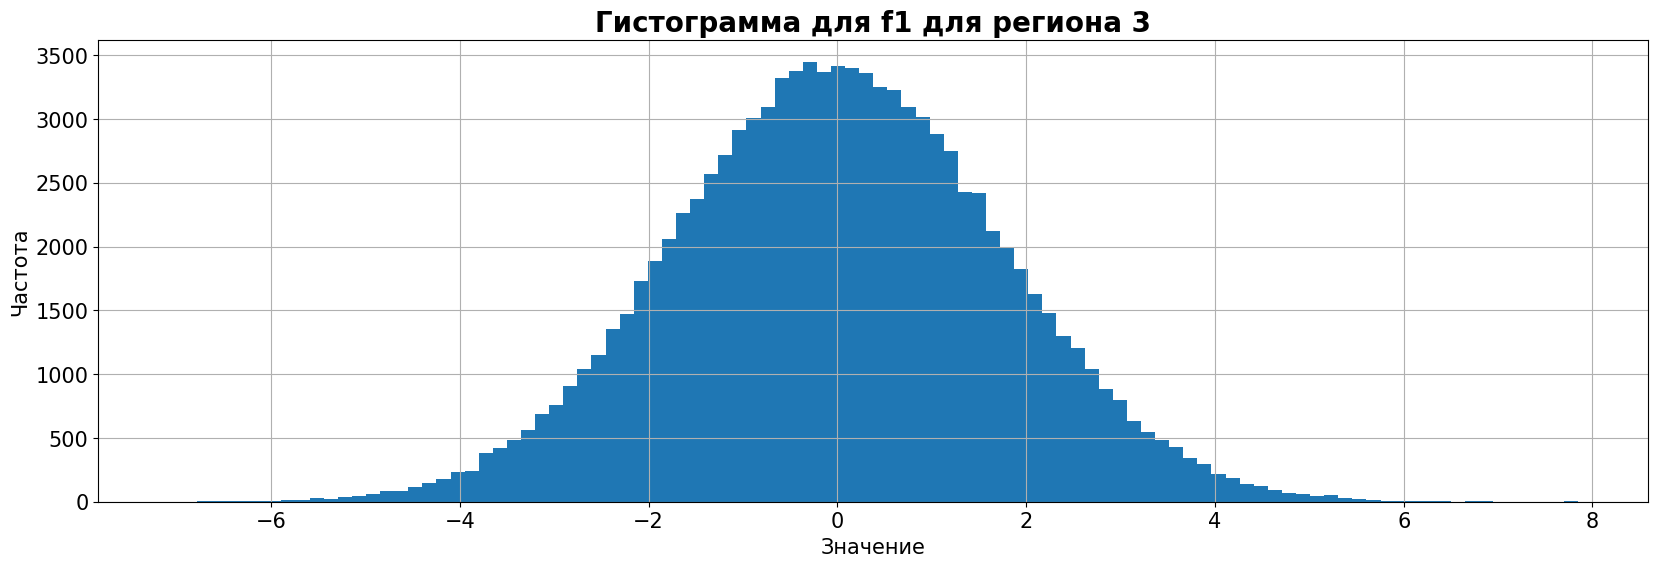

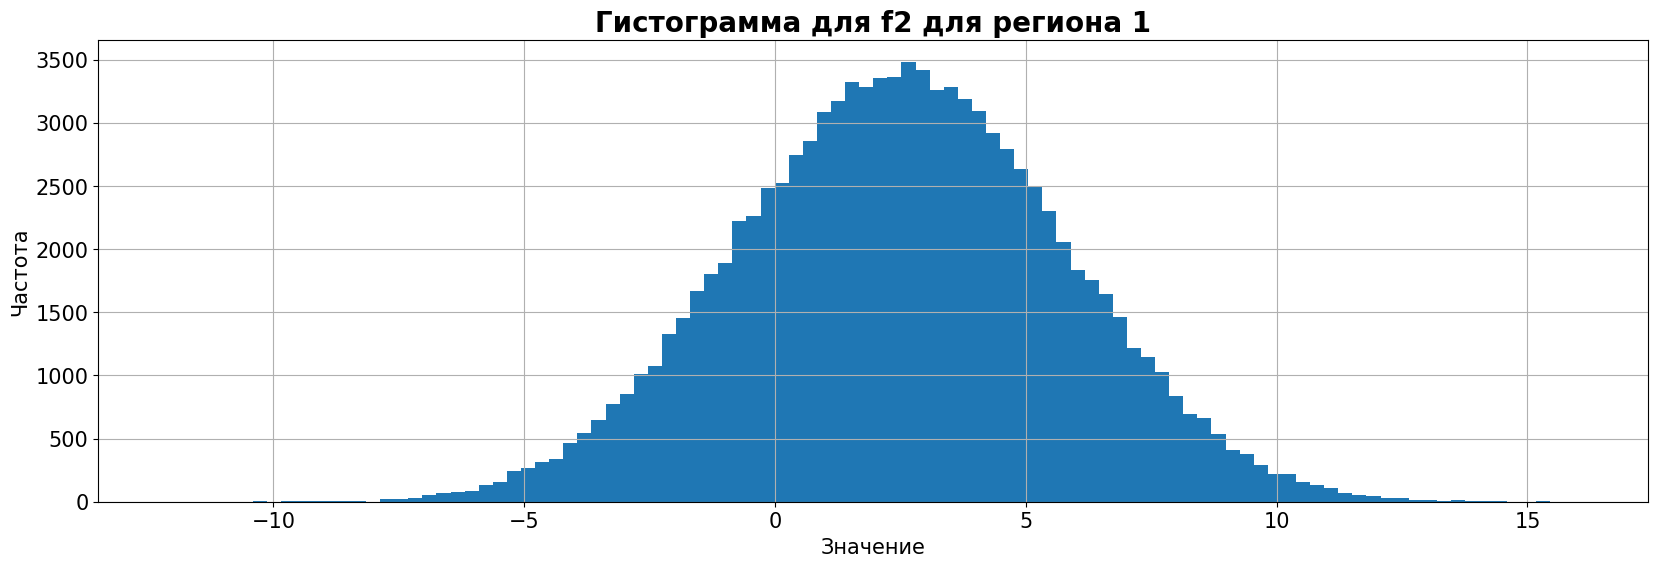

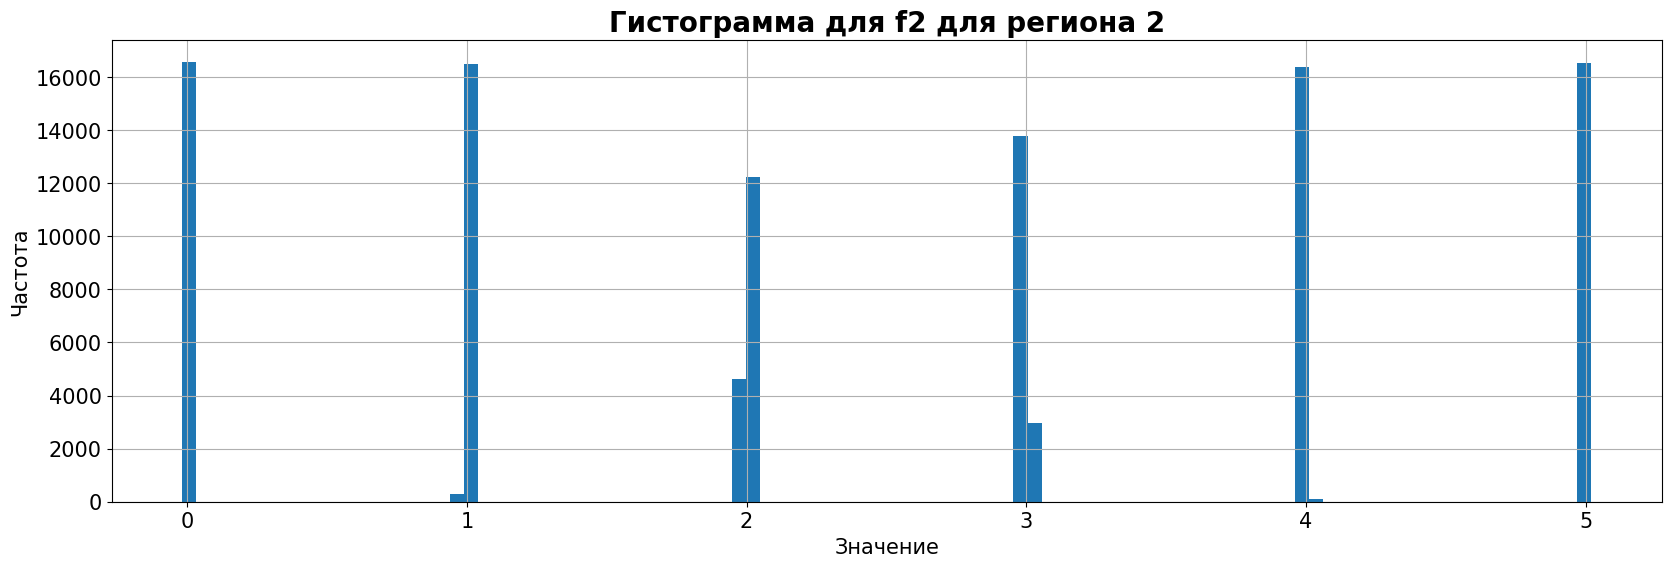

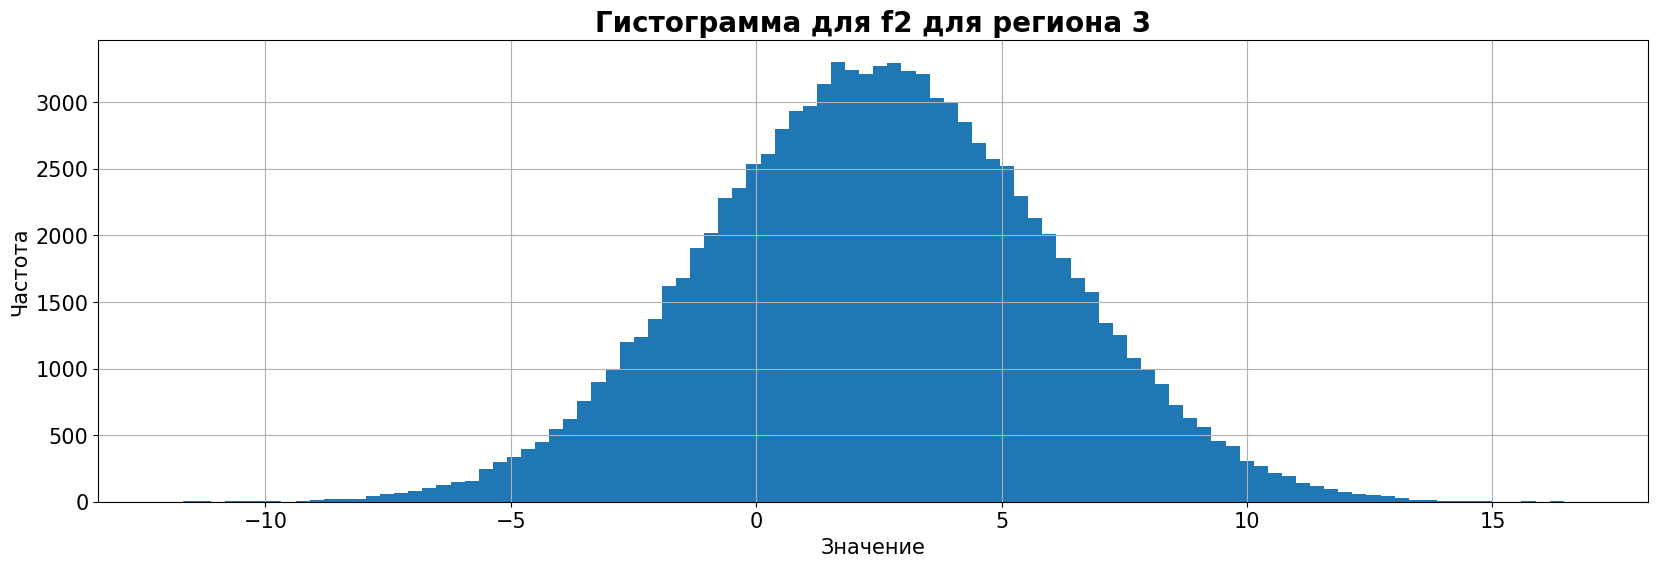

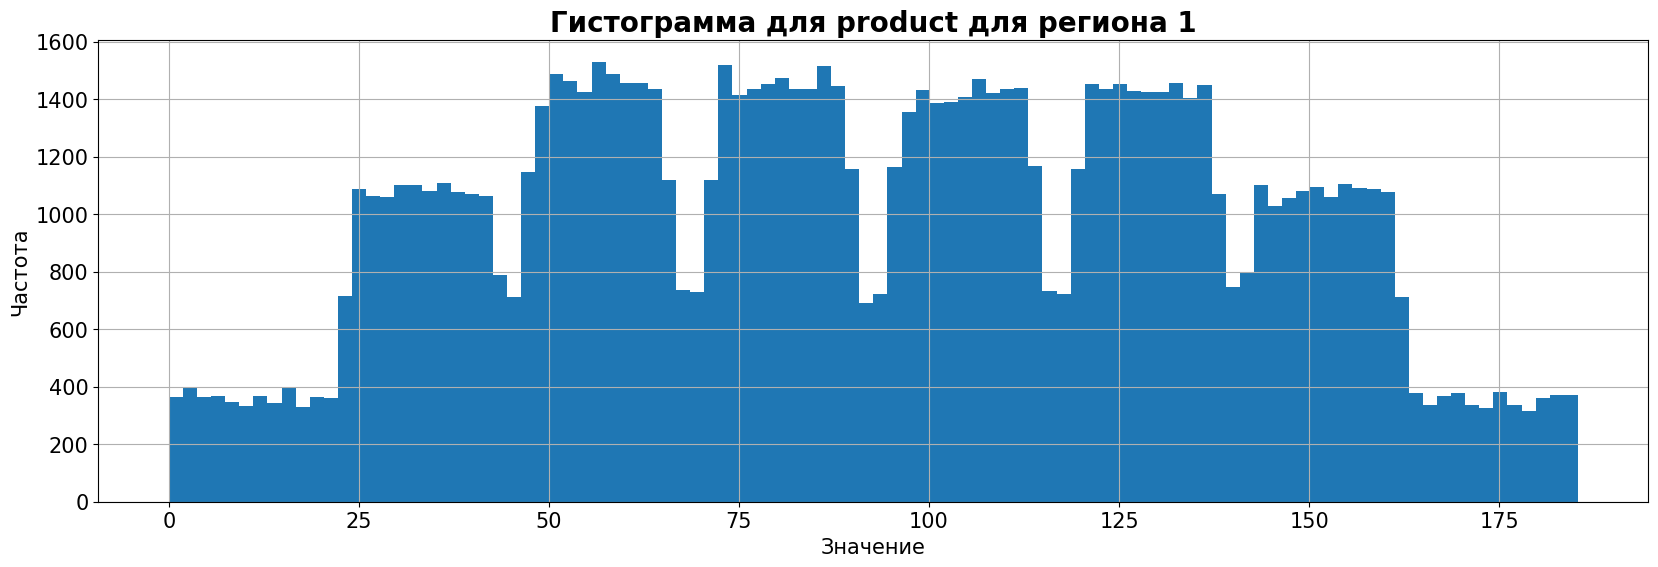

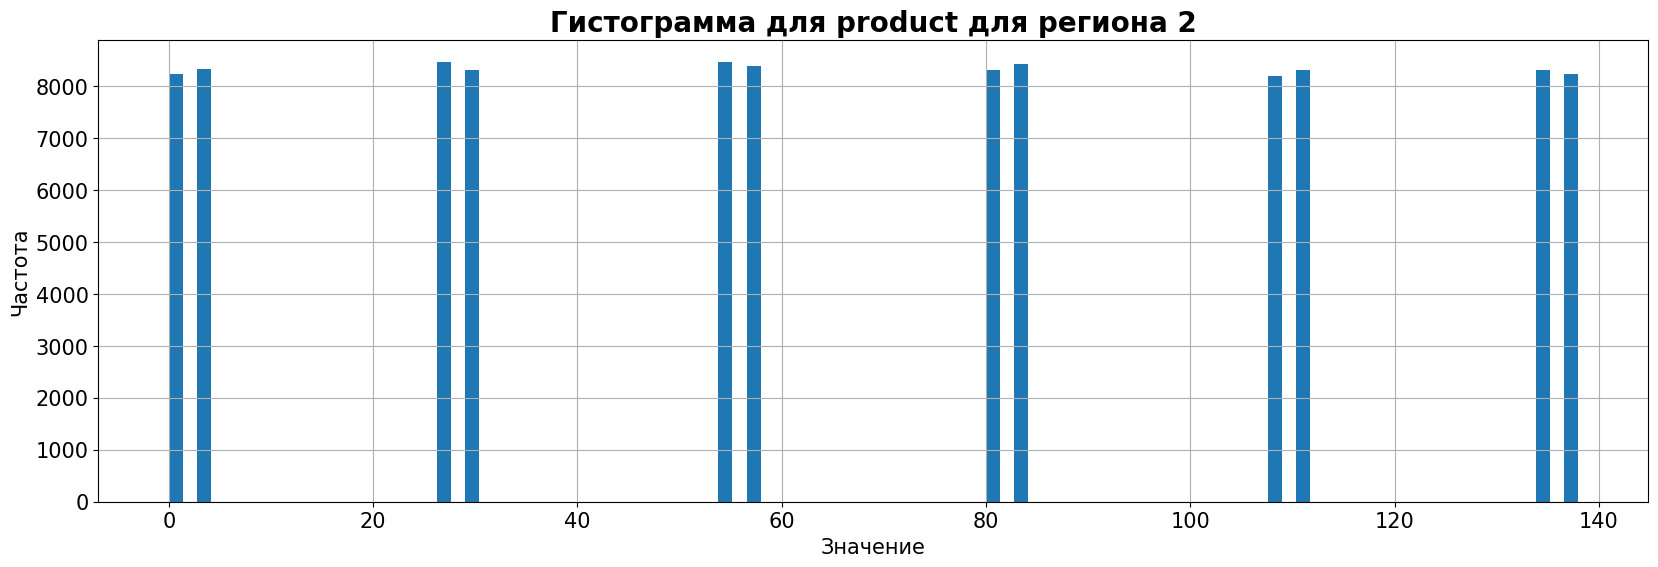

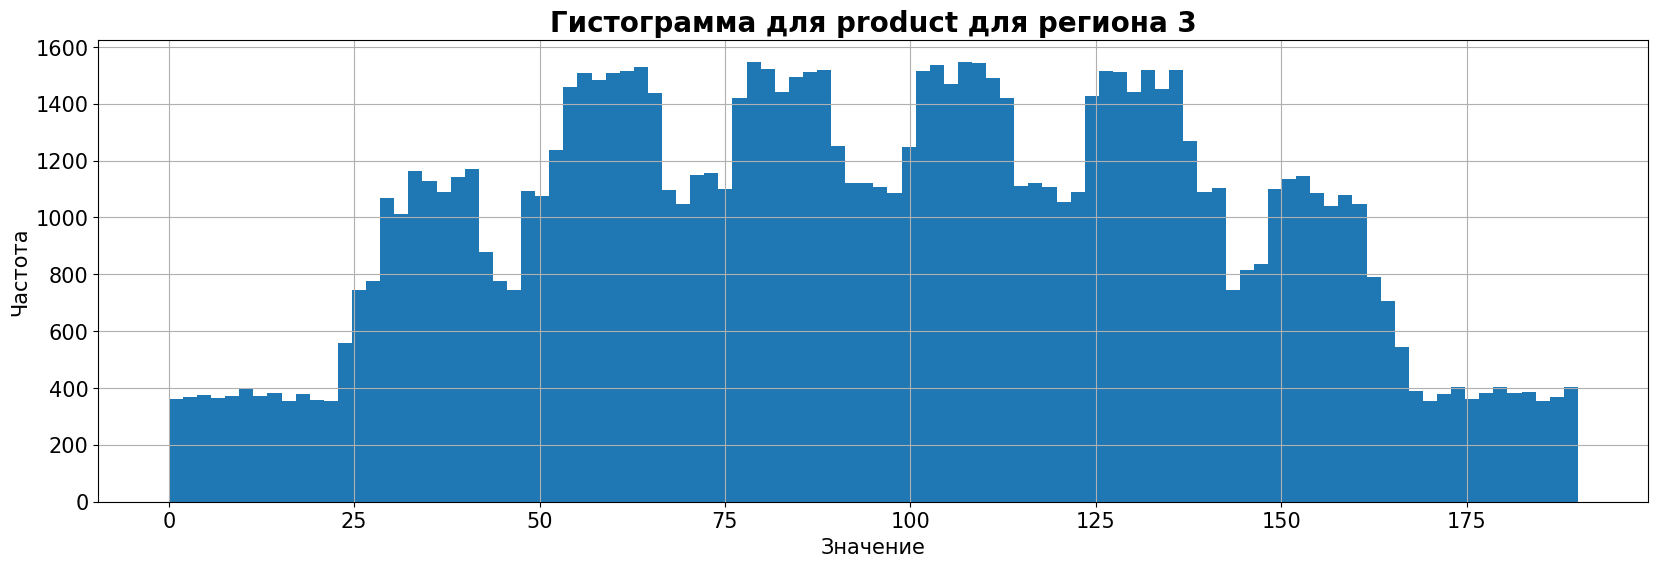

In [12]:
# Проведем визуальный осмотр данных (в разрезе регионов)
for column in df.select_dtypes(include='float64').columns:
    for region in [1, 2, 3]:
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.set_title(f'Гистограмма для {column} для региона {region}', fontsize=20, weight='bold')
        ax.set_xlabel('Значение', fontsize=15)
        ax.set_ylabel('Частота', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        df[df['region'] == region][column].hist(bins=100, ax=ax)

In [13]:
# Посмотрим на значения в столбцах f2 и product для 2 региона
display('f2', df[df['region'] == 2]['f2'].value_counts())
display('product', df[df['region'] == 2]['product'].value_counts())

'f2'

4.00    1
4.00    1
2.00    1
1.00    1
4.00    1
       ..
1.00    1
5.00    1
3.00    1
0.00    1
4.99    1
Name: f2, Length: 100000, dtype: int64

'product'

53.91     8472
26.95     8468
84.04     8431
57.09     8390
3.18      8337
80.86     8320
30.13     8306
134.77    8304
110.99    8303
0.00      8235
137.95    8233
107.81    8201
Name: product, dtype: int64

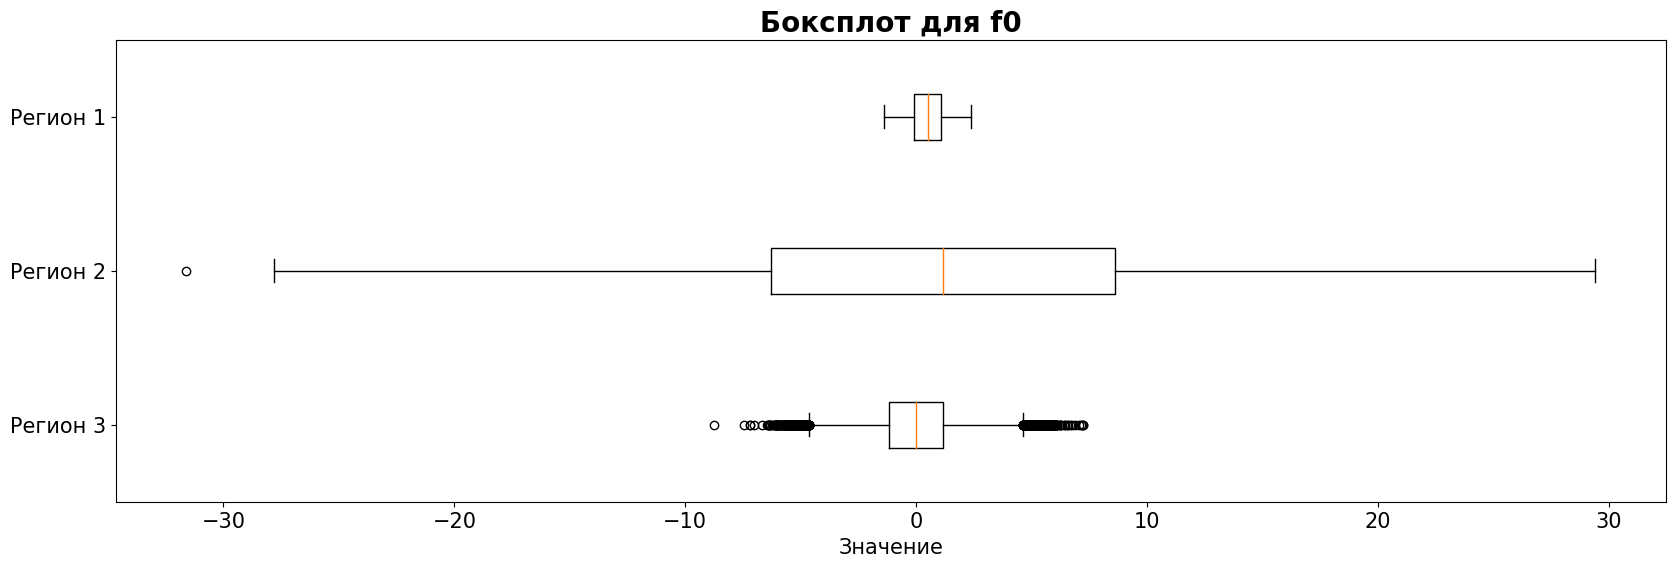

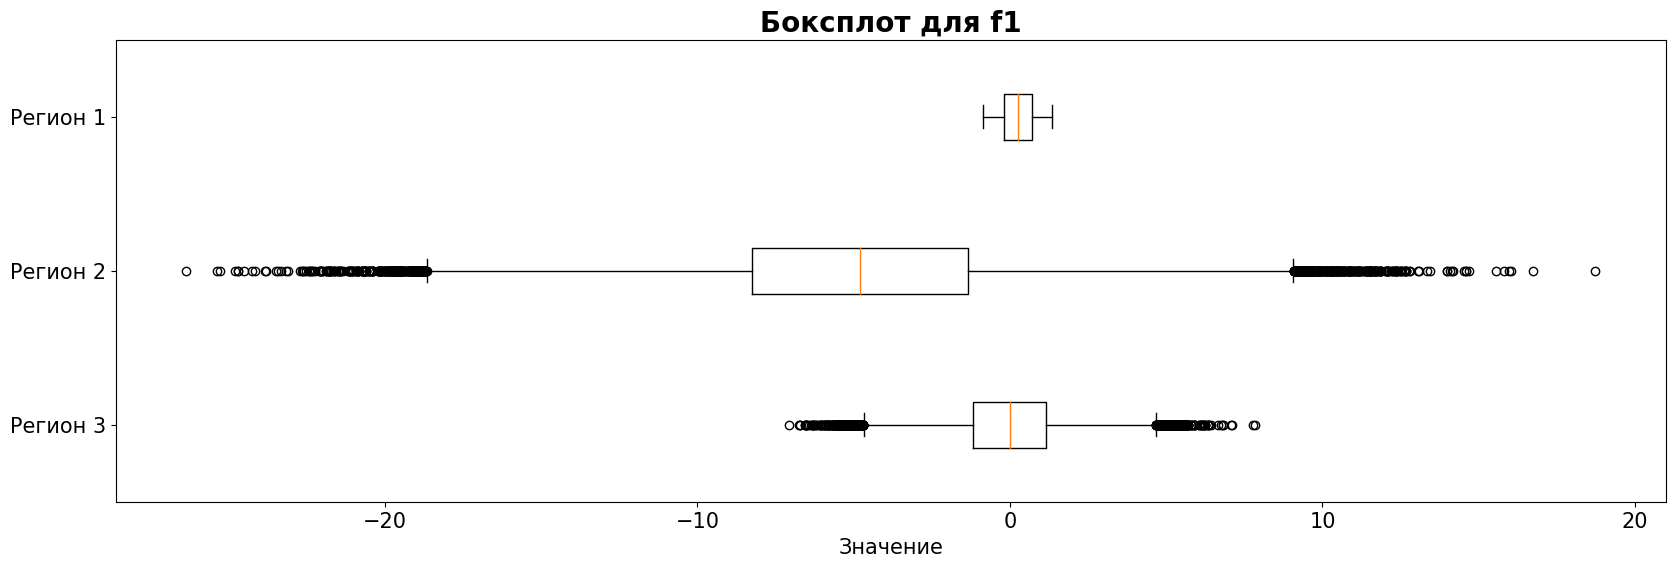

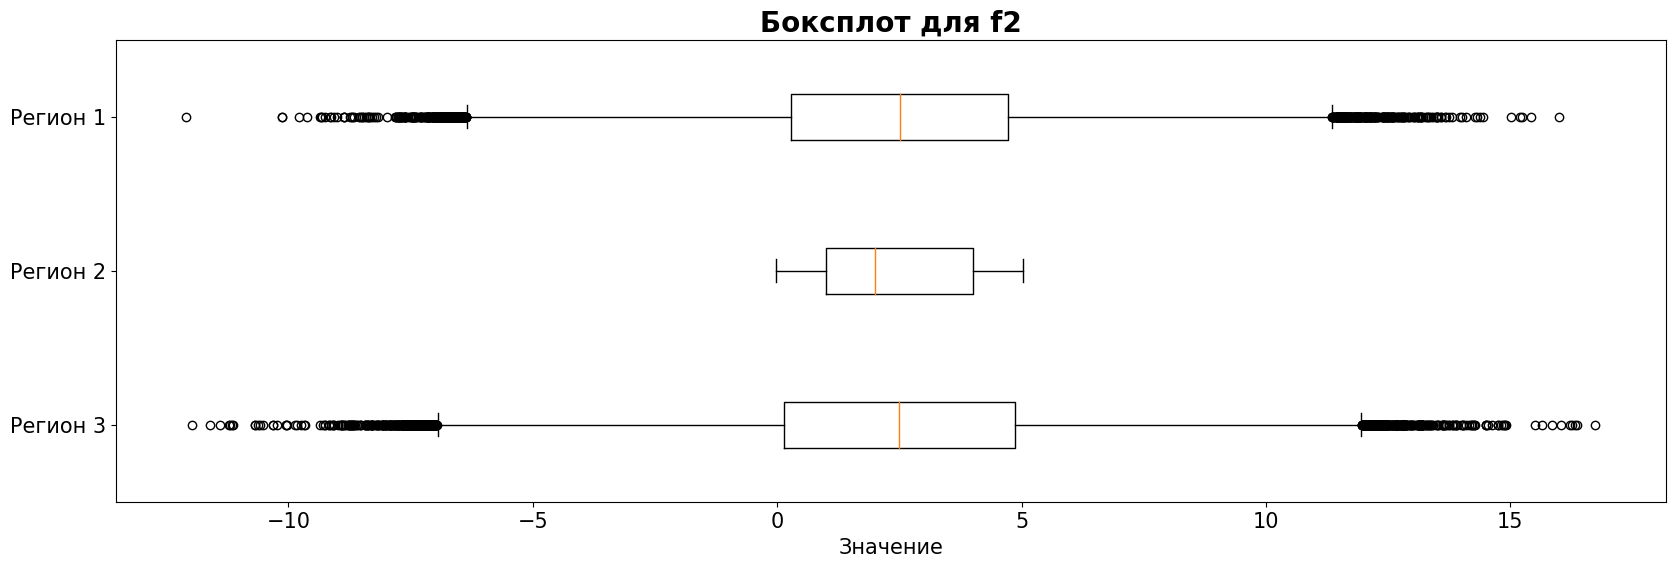

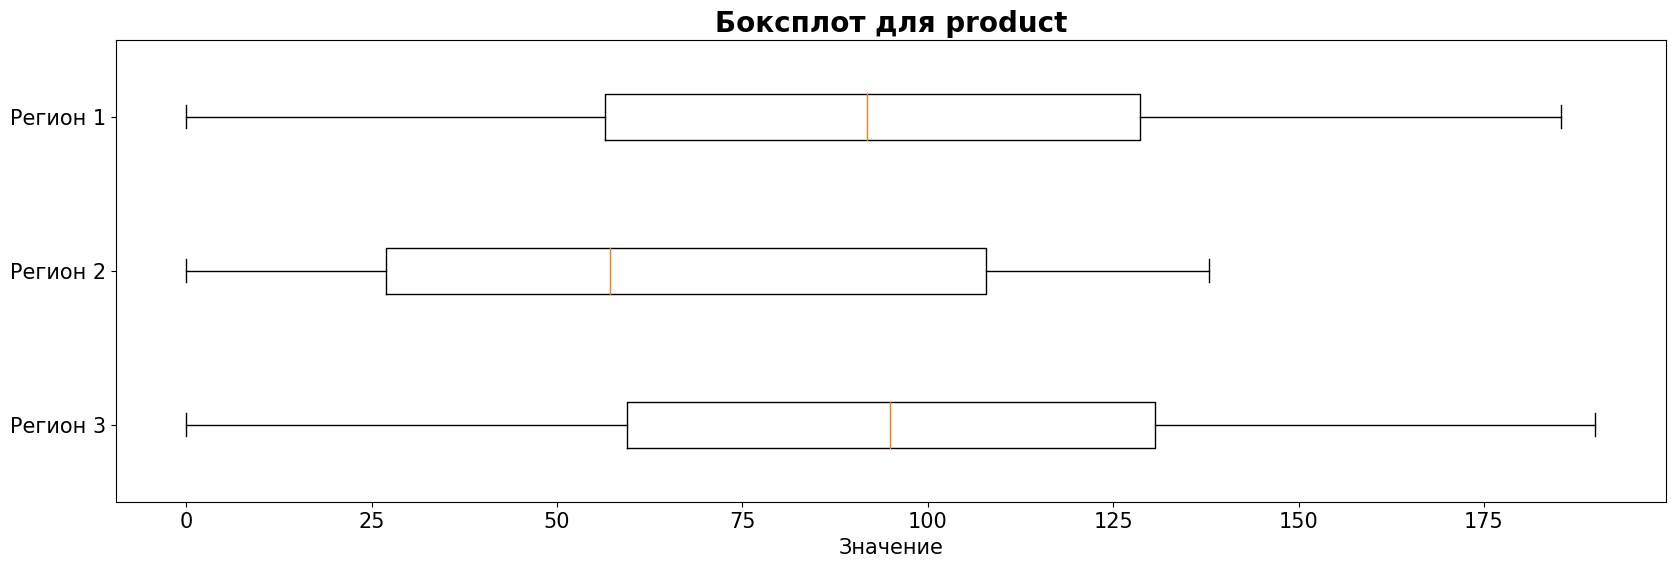

In [14]:
# Проведем визуальный осмотр данных (в разрезе регионов)
for column in df.select_dtypes(include='float64').columns:
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Боксплот для {column}', fontsize=20, weight='bold')
    ax.set_xlabel('Значение', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.boxplot([df[df['region'] == 3][column], df[df['region'] == 2][column], df[df['region'] == 1][column]], vert=False, labels=['Регион 3', 'Регион 2', 'Регион 1'])

In [15]:
# Посмотрем на корреляции product с фичами для каждого региона
for region in range(1, 4):
    display(f'Регион {region}:')
    display(df.drop(columns='id')[df['region'] == region].corr().loc['product'].drop(index=['product', 'region']))

'Регион 1:'

f0    0.14
f1   -0.19
f2    0.48
Name: product, dtype: float64

'Регион 2:'

f0   -0.03
f1   -0.01
f2    1.00
Name: product, dtype: float64

'Регион 3:'

f0   -0.00
f1   -0.00
f2    0.45
Name: product, dtype: float64

**Выводы по первоначальному изучению данных:**
* Столбцы поименованы корректно.
* Типы столбцов определены корректно.
* Пропуски в данных отсутствуют.
* Прямые дубли в данных отсутсвуют.
* Есть незначительное количество дублей id как по всем регионам в целом, так и внутри каждого региона по отдельности. Визуальный осмотр таблиц показывает, что несмотря на совпадающие id сами значения показателей в каждом дубле носят неповторяющийся характер. В связи с этим и с учётом большого количества сэмплов - такое совпадение, возможно, является случайностью. Т.к. сам столбец id для обучения модели неинформативен, количество дублей - незначительное, а также сами повторы не похожи на ошибочные в **целях данной работы пока оставим эти строки без изменений**.
* Визуальный осмотр гистограмм по всем столбцам в разрезе регионов показывает, что данные в зависимости от региона распределены совершенно по-разному. Данные по показателю `f2` во 2 регионе распределены вокруг ряда целых значений (не ясно с чем это связано). Данные по `product` в том же регионе принимают только одно из 12 конкретных значений (причина так же не ясна). Т.к. данные синтетические, оставим эти вопросы за пределами данной работы.
* Картина корреляций таргета с фичами по каждому региону совершенно разная. По 2 региону корреляция с f2 равна 1. Это скорее всего даст почти безошибочные результаты для линейной регрессии по 2 региону.
* Использовать данные по всем регионам для обучения одной большой модели скорее всего невозможно.
* Судя по боксплотам и гистограммам очевидных выбросов, которые стоило бы удалить - нет.

### Подготовка данных

* По результатам осмотра датасетов никакой особой подготовки данных не требуется.

### Выводы

* Данные готовы для построения моделей.
* Модели необходимо строить отдельно по каждому региону. Скорее всего показатели с одними и теми же названиями для разных регионов имеют разную природу.
* Данные синтетические и распределены не всегда нормально.

## Построение модели для предсказания объема запасов в новых скважинах

In [16]:
# Создадим рабочие копии отдельно покаждому региону (id дропнем, т.к. он неинформативен для обучения)
df_1 = original_df_1.copy().drop(columns=['id'])
df_2 = original_df_2.copy().drop(columns=['id'])
df_3 = original_df_3.copy().drop(columns=['id'])

In [17]:
# Займемся регионом номер 1
features_1 = df_1.drop(columns=['product'])
target_1 = df_1['product']

X_train_1, X_dev_1, y_train_1, y_dev_1 = train_test_split(features_1, target_1, test_size=0.25)
scaler_1 = StandardScaler()
scaler_1.fit(X_train_1)
X_train_1_scaled = scaler_1.transform(X_train_1)
X_dev_1_scaled = scaler_1.transform(X_dev_1)

model_1 = LinearRegression()
model_1.fit(X_train_1_scaled, y_train_1)
prediction_1 = model_1.predict(X_dev_1_scaled)
rmse_score_1 = mean_squared_error(y_dev_1, prediction_1, squared=False)
mean_for_prediction_1 = prediction_1.mean()

display(f'RMSE on dev: {rmse_score_1:.2f}, Mean for prediction: {mean_for_prediction_1:.2f}, R2 on dev: {model_1.score(X_dev_1_scaled, y_dev_1):.2%}')

'RMSE on dev: 37.99, Mean for prediction: 92.72, R2 on dev: 27.20%'

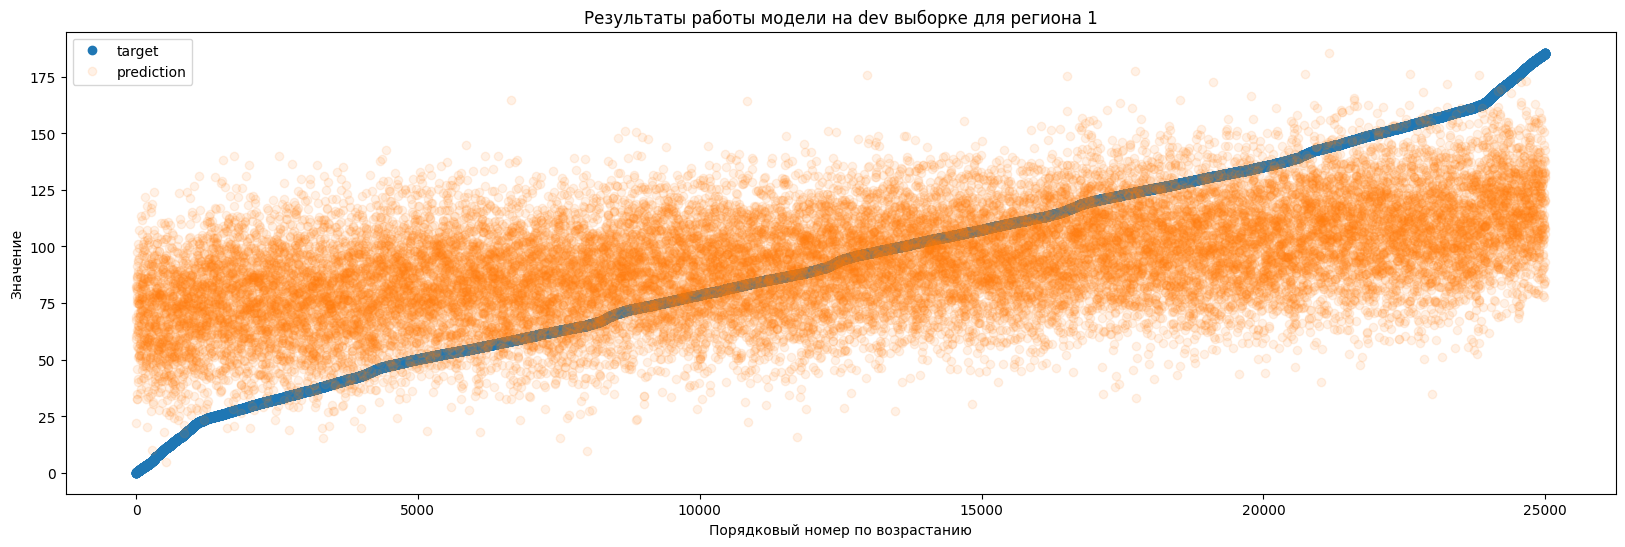

In [18]:
# Сделаем небольшую визуализацию работы модели
data_for_graph = pd.concat([y_dev_1.reset_index(drop=True), pd.Series(prediction_1, name='predictions')], axis='columns').sort_values('product').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Результаты работы модели на dev выборке для региона 1')
ax.set_xlabel('Порядковый номер по возрастанию')
ax.set_ylabel('Значение')
ax.plot(data_for_graph.index, data_for_graph['product'].values, 'o', label='target')
ax.plot(data_for_graph.index, data_for_graph['predictions'].values, 'o', alpha=0.1, label='prediction')
ax.legend();

Качество прогноза очень плохое. В связи с ограничением по выбору модели далее будем работать с тем результатом, какой имеем.

In [19]:
# Займемся регионом номер 2
features_2 = df_2.drop(columns=['product'])
target_2 = df_2['product']

X_train_2, X_dev_2, y_train_2, y_dev_2 = train_test_split(features_2, target_2, test_size=0.25)
scaler_2 = StandardScaler()
scaler_2.fit(X_train_2)
X_train_2_scaled = scaler_2.transform(X_train_2)
X_dev_2_scaled = scaler_2.transform(X_dev_2)

model_2 = LinearRegression()
model_2.fit(X_train_2_scaled, y_train_2)
prediction_2 = model_2.predict(X_dev_2_scaled)
rmse_score_2 = mean_squared_error(y_dev_2, prediction_2, squared=False)
mean_for_prediction_2 = prediction_2.mean()

display(f'RMSE on dev: {rmse_score_2:.2f}, Mean for prediction: {mean_for_prediction_2:.2f}, R2 on dev: {model_2.score(X_dev_2_scaled, y_dev_2):.2%}')

'RMSE on dev: 0.88, Mean for prediction: 68.98, R2 on dev: 99.96%'

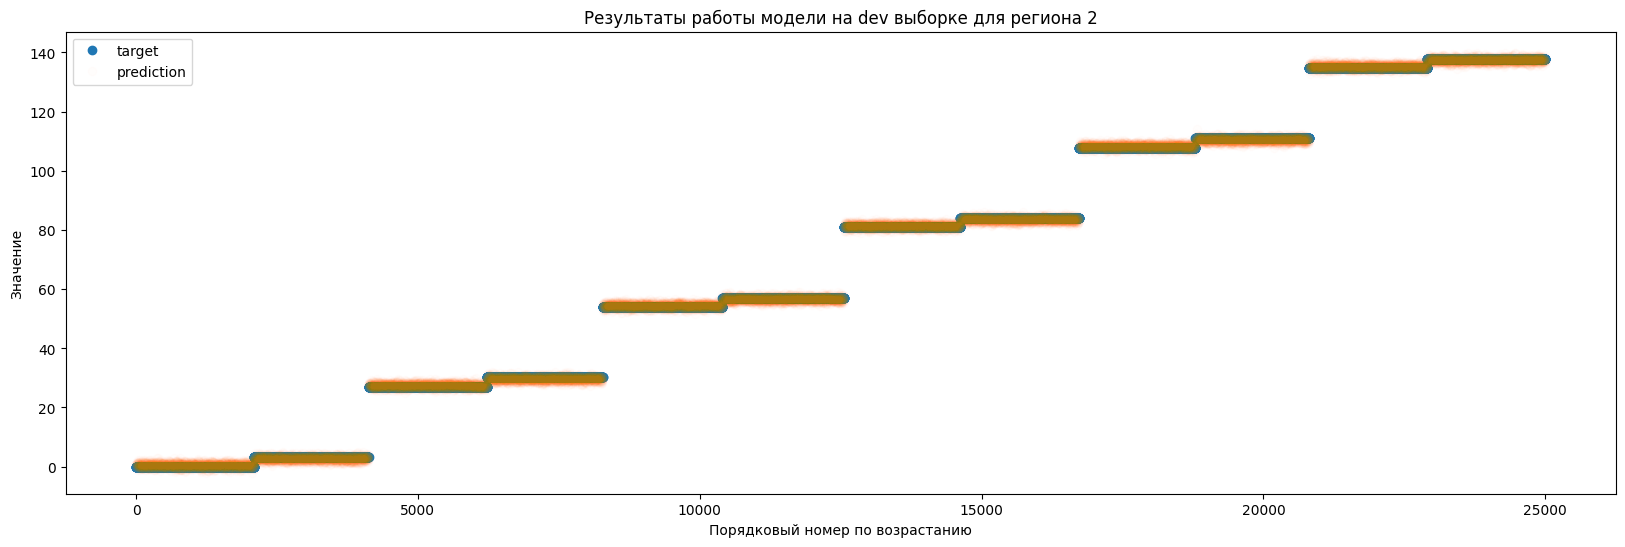

In [20]:
# Сделаем небольшую визуализацию работы модели
data_for_graph = pd.concat([y_dev_2.reset_index(drop=True), pd.Series(prediction_2, name='predictions')], axis='columns').sort_values('product').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Результаты работы модели на dev выборке для региона 2')
ax.set_xlabel('Порядковый номер по возрастанию')
ax.set_ylabel('Значение')
ax.plot(data_for_graph.index, data_for_graph['product'].values, 'o' , label='target')
ax.plot(data_for_graph.index, data_for_graph['predictions'].values, 'o', alpha=0.01, label='prediction')
ax.legend();

За счёт наличия корреляции качество предсказания отличное. R2 почти равен 1.

In [21]:
# Займемся регионом номер 3
features_3 = df_3.drop(columns=['product'])
target_3 = df_3['product']

X_train_3, X_dev_3, y_train_3, y_dev_3 = train_test_split(features_3, target_3, test_size=0.25)
scaler_3 = StandardScaler()
scaler_3.fit(X_train_3)
X_train_3_scaled = scaler_3.transform(X_train_3)
X_dev_3_scaled = scaler_3.transform(X_dev_3)

model_3 = LinearRegression()
model_3.fit(X_train_3_scaled, y_train_3)
prediction_3 = model_3.predict(X_dev_3_scaled)
rmse_score_3 = mean_squared_error(y_dev_3, prediction_3, squared=False)
mean_for_prediction_3 = prediction_3.mean()

display(f'RMSE on dev: {rmse_score_3:.2f}, Mean for prediction: {mean_for_prediction_3:.2f}, R2 on dev: {model_3.score(X_dev_3_scaled, y_dev_3):.2%}')

'RMSE on dev: 40.18, Mean for prediction: 95.10, R2 on dev: 19.91%'

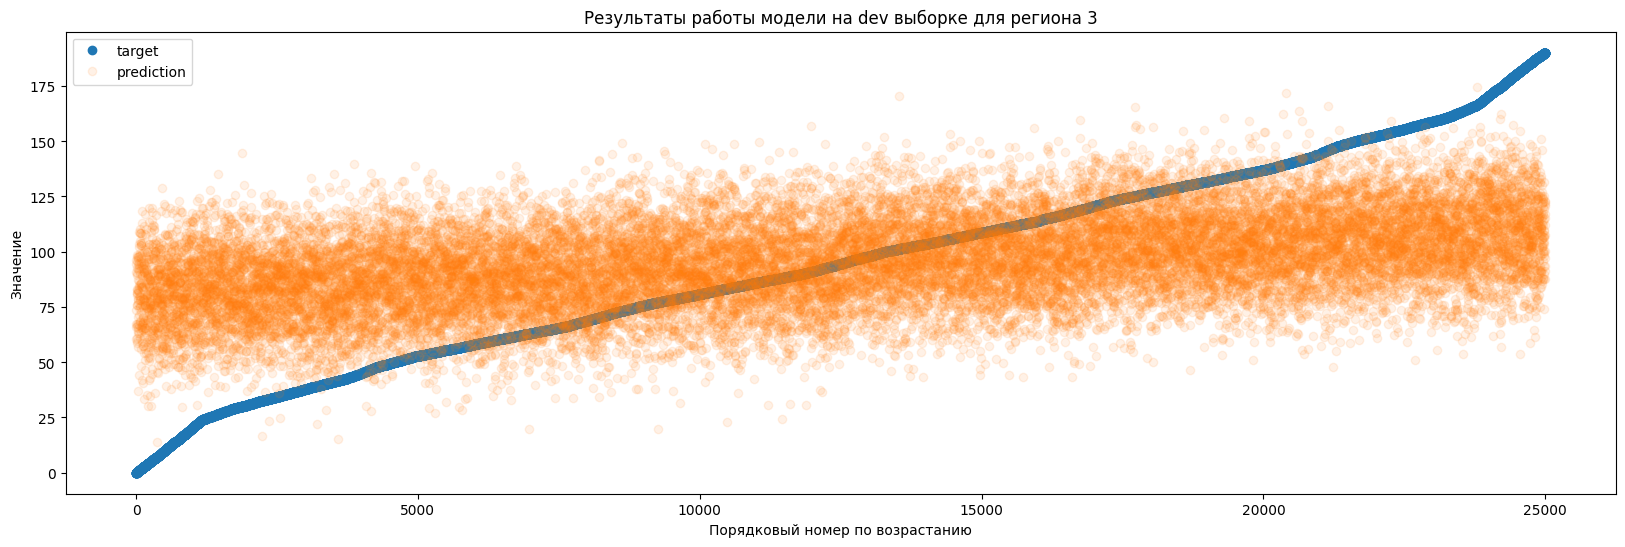

In [22]:
# Сделаем небольшую визуализацию работы модели
data_for_graph = pd.concat([y_dev_3.reset_index(drop=True), pd.Series(prediction_3, name='predictions')], axis='columns').sort_values('product').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Результаты работы модели на dev выборке для региона 3')
ax.set_xlabel('Порядковый номер по возрастанию')
ax.set_ylabel('Значение')
ax.plot(data_for_graph.index, data_for_graph['product'].values, 'o' , label='target')
ax.plot(data_for_graph.index, data_for_graph['predictions'].values, 'o', alpha=0.1, label='prediction')
ax.legend();

Качество предсказания также очень низкое. В связи с ограничением по выбору модели далее будем работать с тем результатом, какой имеем.

**Выводы:**
* Результаты применения линейной регрессии в лоб для представленных данных даёт приемлемый результат только для региона 2 в связи с наличием признака, имеющего почти полную корреляцию с целевым показателем.
* Результаты показателя детерминации для регионов 1 и 3 больше 0, что свидетельствует о результате немного лучшем, чем dumb classifier.

## Выбор скважины с самыми высокими оценками

In [23]:
# Сохраним необходимые значения из условия задачи в отдельных переменных
NUMBER_OF_POINTS_FOR_RESEARCH = 500
NUMBER_OF_BEST_POINTS = 200
BUDGET = 10 ** 10
INCOME_FOR_THOUSAND_BARRELS = 450 * 10 ** 3
ACCEPTABLE_PROBABILITY_OF_LOSS = 0.025
NUMBER_OF_BOOTSTRAP_CYCLES = 10 ** 3

In [24]:
# Расчитаем объём безубыточности новой скважины в тыс. баррелей
break_even_production = BUDGET / INCOME_FOR_THOUSAND_BARRELS
display(f'Минимальный объем запасов для окупаемости {NUMBER_OF_BEST_POINTS} скважин: {break_even_production:.0f} тыс. баррелей')

'Минимальный объем запасов для окупаемости 200 скважин: 22222 тыс. баррелей'

In [25]:
# Посмотрим на средние запасы на скважину по всей dev выборке для регионов и сравним с объемом, необходимым для безубыточности
mean_product_1 = y_dev_1.mean()
mean_product_2 = y_dev_2.mean()
mean_product_3 = y_dev_3.mean()

display(f'Средний размер запасов на скважину по регионам 1, 2 и 3 соответственно: {mean_product_1:.0f}, {mean_product_2:.0f}, {mean_product_3:.0f} тыс. баррелей.')
display(f'Средний размер запасов на скважину, необходимый для достижения точки безубыточности в регионе: {break_even_production / NUMBER_OF_BEST_POINTS:.0f} тыс. баррелей')

'Средний размер запасов на скважину по регионам 1, 2 и 3 соответственно: 93, 69, 95 тыс. баррелей.'

'Средний размер запасов на скважину, необходимый для достижения точки безубыточности в регионе: 111 тыс. баррелей'

In [26]:
# Выберем 500 точек для исследования по каждому региону из dev выборок
X_for_research_1 = X_dev_1.sample(NUMBER_OF_POINTS_FOR_RESEARCH)
X_for_research_2 = X_dev_2.sample(NUMBER_OF_POINTS_FOR_RESEARCH)
X_for_research_3 = X_dev_3.sample(NUMBER_OF_POINTS_FOR_RESEARCH)

In [27]:
# Посчитаем прогнозы по выбранным точкам и выберем 200 лучших
prediction_for_research_1 = pd.Series(prediction_1, index=X_dev_1.index)[X_for_research_1.index].sort_values(ascending=False).iloc[:NUMBER_OF_BEST_POINTS]
prediction_for_research_2 = pd.Series(prediction_2, index=X_dev_2.index)[X_for_research_2.index].sort_values(ascending=False).iloc[:NUMBER_OF_BEST_POINTS]
prediction_for_research_3 = pd.Series(prediction_3, index=X_dev_3.index)[X_for_research_3.index].sort_values(ascending=False).iloc[:NUMBER_OF_BEST_POINTS]
display(f'Для региона 1 отобраны {NUMBER_OF_BEST_POINTS} лучших скважины со средней величиной запасов {prediction_for_research_1.mean():.2f} тыс. баррелей и суммарным объемом запасов {prediction_for_research_1.sum():.0f} тыс. баррелей.')
display(f'Для региона 2 отобраны {NUMBER_OF_BEST_POINTS} лучших скважины со средней величиной запасов {prediction_for_research_2.mean():.2f} тыс. баррелей и суммарным объемом запасов {prediction_for_research_2.sum():.0f} тыс. баррелей.')
display(f'Для региона 3 отобраны {NUMBER_OF_BEST_POINTS} лучших скважины со средней величиной запасов {prediction_for_research_3.mean():.2f} тыс. баррелей и суммарным объемом запасов {prediction_for_research_3.sum():.0f} тыс. баррелей.')

'Для региона 1 отобраны 200 лучших скважины со средней величиной запасов 113.93 тыс. баррелей и суммарным объемом запасов 22786 тыс. баррелей.'

'Для региона 2 отобраны 200 лучших скважины со средней величиной запасов 114.26 тыс. баррелей и суммарным объемом запасов 22851 тыс. баррелей.'

'Для региона 3 отобраны 200 лучших скважины со средней величиной запасов 112.03 тыс. баррелей и суммарным объемом запасов 22407 тыс. баррелей.'

**Выводы:**
* Средняя фактическая величина запасов на скважину по рассматриваемым регионам на dev выборке составляет от 69 до 95 тыс. баррелей, что значительно ниже точки безубыточности в размере 111 тыс. баррелей. Для достижения целевых показателей по прибыльности необходим механизм выбора лучших скважин.
* Ранжирование согласно оценке по регионам по суммарному количеству запасов на 200 отобранных лучших скважин от лучших к худшим: Регион 2, Регион 1, Регион 3.
* Суммарное оценочное количество запасов по каждому региону на 200 отобранных лучших скважин очень близко к уровню безубыточности, но всегда выше этого уровня.

## Определение региона с максимальной суммарной прибылью отобранных скважин

In [28]:
# Произведем расчёт оценки прибыли по каждому из регионов
profit_1 = prediction_for_research_1.sum() * INCOME_FOR_THOUSAND_BARRELS - BUDGET
profit_2 = prediction_for_research_2.sum() * INCOME_FOR_THOUSAND_BARRELS - BUDGET
profit_3 = prediction_for_research_3.sum() * INCOME_FOR_THOUSAND_BARRELS - BUDGET
display(f'Оценочная прибыль по региону 1 составляет {profit_1 / 10**6:.0f} млн рублей.')
display(f'Оценочная прибыль по региону 2 составляет {profit_2 / 10**6:.0f} млн рублей.')
display(f'Оценочная прибыль по региону 3 составляет {profit_3 / 10**6:.0f} млн рублей.')

'Оценочная прибыль по региону 1 составляет 254 млн рублей.'

'Оценочная прибыль по региону 2 составляет 283 млн рублей.'

'Оценочная прибыль по региону 3 составляет 83 млн рублей.'

In [29]:
# Напишем функии для асчёта прибыли и визуализации бутстрапа

# Расчёт прибыли
def calculate_profit(X_dev, y_dev, prediction):
    # Выберем 500 различных точек (с повторением для bootstrap).
    X_for_research = X_dev.sample(NUMBER_OF_POINTS_FOR_RESEARCH, replace=True)
    # Выберем 200 лучших точек из 500
    prediction_for_research = pd.Series(prediction, index=X_dev.index)[X_for_research.index].sort_values(ascending=False).iloc[:NUMBER_OF_BEST_POINTS]
    # Выберем фактическое количество запасов по лучшим 200 точкам и просуммируем
    factual_production_for_research = y_dev[prediction_for_research.index].sum()
    # Посчитаем профит на фактических данных по запасам
    profit = factual_production_for_research * INCOME_FOR_THOUSAND_BARRELS - BUDGET
    return profit
    
# Отчёт по бутстрапу
def print_profit_report(profit_values, region_number):
    # Рассчитаем cреднюю прибыль
    mean_profit = pd.Series(profit_values).mean()
    # Рассчитаем границы доверительного 95% интервала по прибыли для каждого региона
    lower = pd.Series(profit_values).quantile(q=ACCEPTABLE_PROBABILITY_OF_LOSS)
    higher = pd.Series(profit_values).quantile(q=1-ACCEPTABLE_PROBABILITY_OF_LOSS)
    # Рассчитаем риск получить отрицательную прибыль для каждого региона
    risk = (pd.Series(profit_values) < 0).mean()
   
    display(f'------------------Регион {region_number}-----------------')
    display(f'Средняя прибыль на фактических данных: {mean_profit/10**6:.0f} млн рублей.')
    display(f'Доверительный 95% интервал по прибыли для региона {region_number} в млн рублей: ({lower/10**6:.2f}, {higher/10**6:.2f})')
    display(f'Вероятность получения отрицательной прибыли для региона {region_number}: {risk:.2%}')
    if lower < 0:
        display(f'Вероятность получения убытков в регионе более 2,5%. Регион {region_number} выбывает из приоритизации.')
    
    # Визуализируем распределения прибыли в результате bootstrap
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Прибыль в регионе {region_number}', fontsize=20, weight='bold')
    ax.set_xlabel('Прибыль, млн руб.', fontsize=15)
    ax.set_ylabel('Частота', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.plot([lower/10**6,lower/10**6], [0, 40], '--')
    ax.plot([higher/10**6, higher/10**6], [0, 40], '--')
    pd.Series([i/10**6 for i in profit_values]).hist(bins=100, ax=ax)
    plt.show();
        

'------------------Регион 1-----------------'

'Средняя прибыль на фактических данных: 449 млн рублей.'

'Доверительный 95% интервал по прибыли для региона 1 в млн рублей: (-97.35, 975.43)'

'Вероятность получения отрицательной прибыли для региона 1: 5.40%'

'Вероятность получения убытков в регионе более 2,5%. Регион 1 выбывает из приоритизации.'

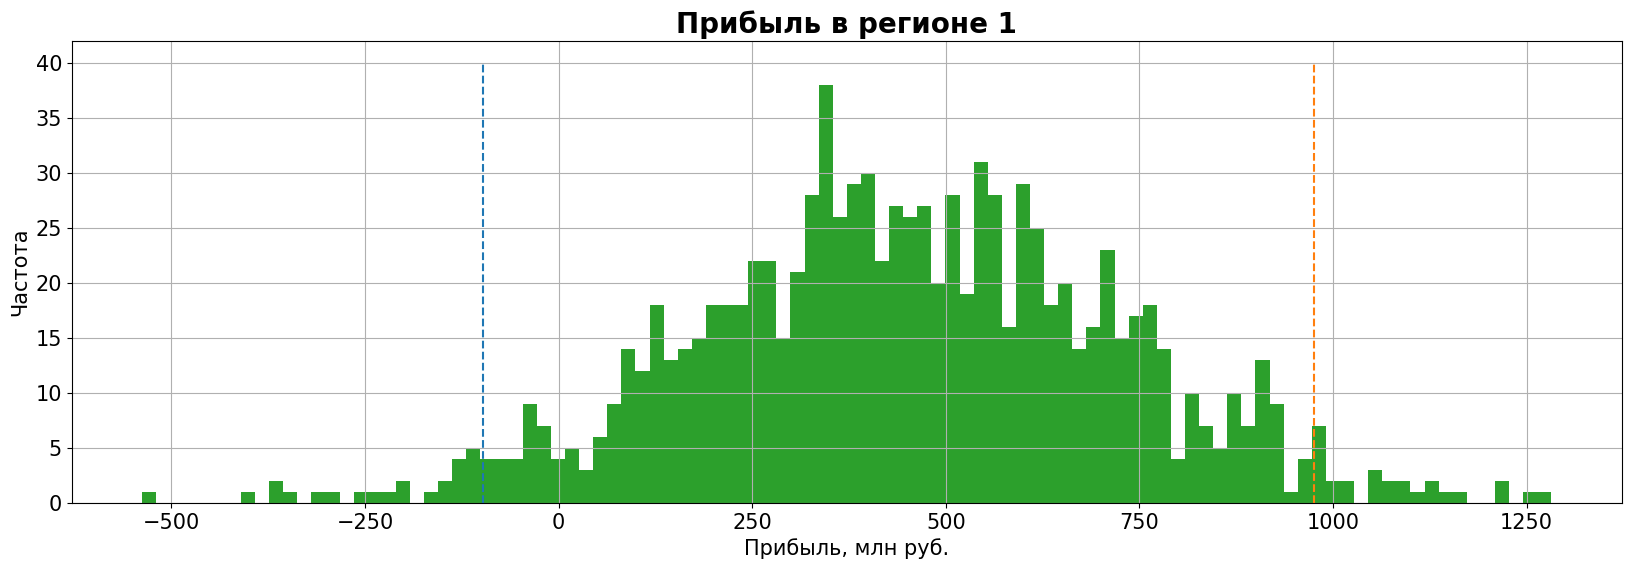

'------------------Регион 2-----------------'

'Средняя прибыль на фактических данных: 461 млн рублей.'

'Доверительный 95% интервал по прибыли для региона 2 в млн рублей: (77.43, 854.76)'

'Вероятность получения отрицательной прибыли для региона 2: 1.10%'

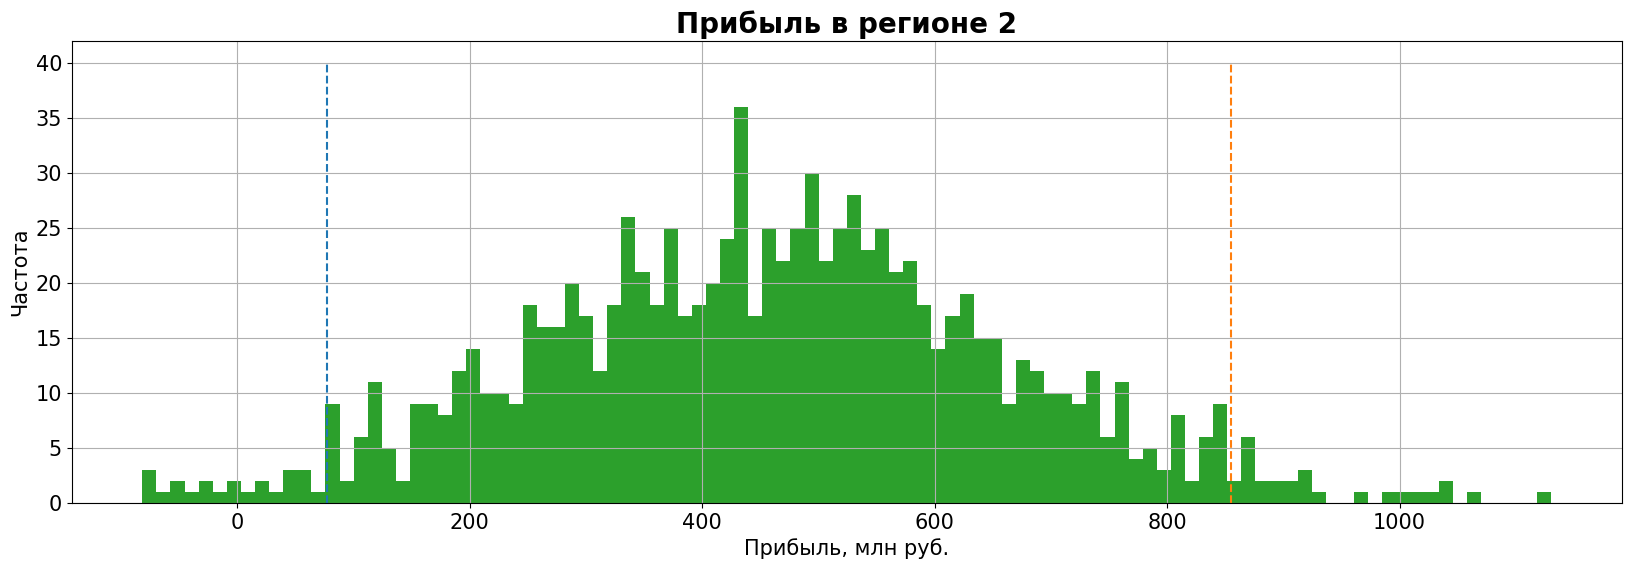

'------------------Регион 3-----------------'

'Средняя прибыль на фактических данных: 351 млн рублей.'

'Доверительный 95% интервал по прибыли для региона 3 в млн рублей: (-178.59, 875.35)'

'Вероятность получения отрицательной прибыли для региона 3: 9.20%'

'Вероятность получения убытков в регионе более 2,5%. Регион 3 выбывает из приоритизации.'

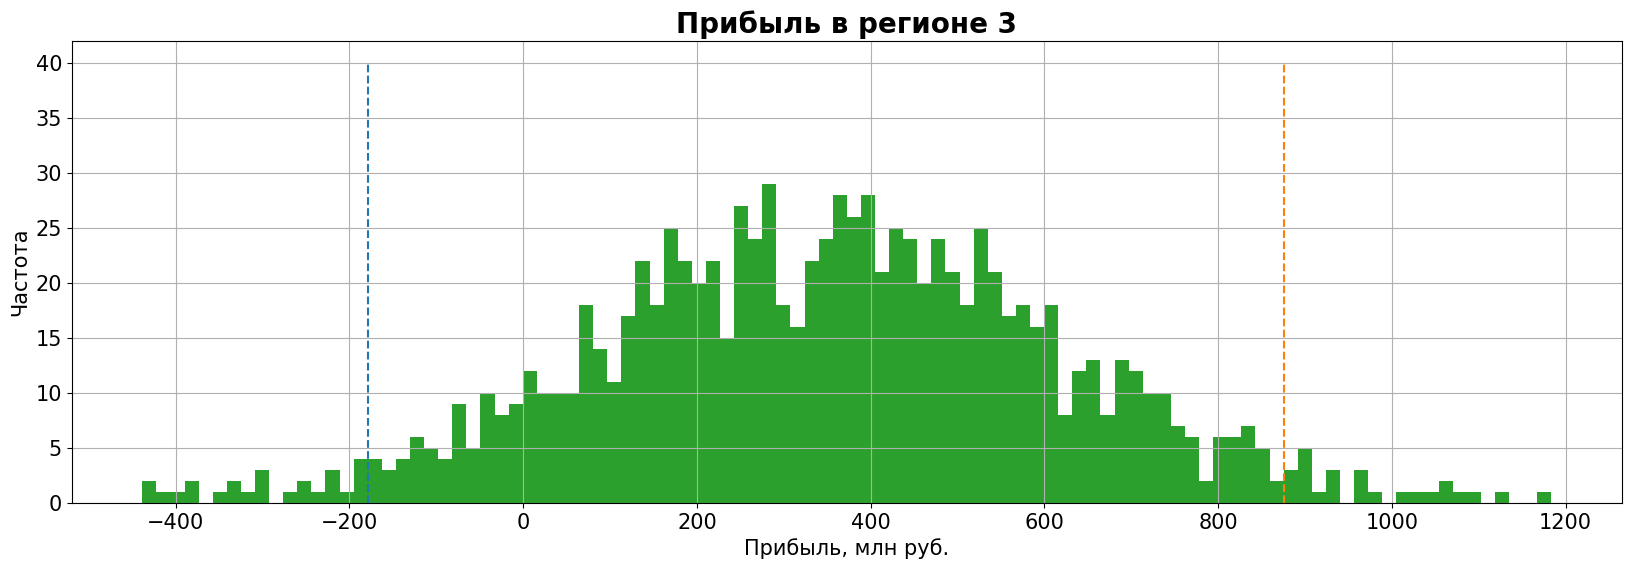

In [30]:
# Используем технику bootstrap для того, чтобы определить 95% доверительный интервал по прибыли для каждого региона, основываясь на фактических данных
profit_values_1 = []
profit_values_2 = []
profit_values_3 = []
        
for i in range(NUMBER_OF_BOOTSTRAP_CYCLES):
    # Расчитаем профит и сохраним результат
    profit_values_1.append(calculate_profit(X_dev_1, y_dev_1, prediction_1))
    profit_values_2.append(calculate_profit(X_dev_2, y_dev_2, prediction_2))
    profit_values_3.append(calculate_profit(X_dev_3, y_dev_3, prediction_3))
    
for i, profit_values in enumerate([profit_values_1, profit_values_2, profit_values_3]):
    print_profit_report(profit_values, i+1)

**Выводы:**
* 95% доверительные интервалы по прибыли для регионов 1 и 3 заходят в отрицательную область.
* Риск получить отрицательную прибыль для этих регионов составляют ~5% и ~9% соответственно.
* Регионы номер 1 и 3 имееют вероятность получить по 200 скважинам запасов ниже точки безубыточности более 2,5% и поэтому выбывают из списка регионов, приемлемых для дальнейшего бурения.
* Прибыльность региона 2 напротив имеет отрицательное значение всего в ~1% случаев. Средняя прибыль на фактических данных для 2 региона составила +461 млн рублей.
* **Итоговый выбранный лучший регион для дальнейшего бурения: Регион 2.**

## Итоговые выводы по проекту

**В процессе работы над проектом были:**
* Загружены и изучены геологические данные по 3 регионам. Данные были практически готовы к обучению. Пропусков, дублей необходимых для корректировки не обнаружено.
* Проведен визуальный осмотр данных. Данные синтетические, имеют разные в зависимости от региона и довольно нестандартные распределения. Есть как плавные распределения, так и дискретные. Очевидных выбросов для удаления не обнаружено. В регионе 2 обнаружена корреляция показателя f2 с таргетом на уровне более 99%.
* Обучены 3 отдельных модели линейной регрессии по каждому региону. По регионам 1 и 3 коэффициент детерминации хоть и больше 0, но составляет 27% и 19% соответственно, что говорит о не самой лучше предсказательной способности линейной регрессии в конкретном случае. По моделям 1 и 3 наблюдаются очень высокие среднеквадратичные отклонения на dev выборках. За счёт параметра с высокой корреляцией с целевым показателям - модель номер 3 напротив дает очень хорошие предсказания.
* Рассчитана точка безубыточности для суммарных запасов по региону для окупаемости бюджета в 10 млрд рублей. Она составила 22 222 тыс. баррелей.
* Средняя фактическая величина запасов на скважину по рассматриваемым регионам на dev выборке составляет от 69 до 95 тыс. баррелей, что значительно ниже точки безубыточности в размере 111 тыс. баррелей. Для достижения целевых показателей по прибыльности необходим механизм выбора лучших скважин.
* Проведен эксперимент по выбору 500 случайных точек, предсказанию по ним запасов с использованием обученных моделей, выбором из итогов 200 лучших точек для бурения.
    * В результате оценка прибыли по регионам 1, 2 и 3 составила соответственно +254, +283 и + 83 млн рублей.
    * Использование техники bootstrap, фактических даных по запасам и расчёта на из основе доверительного интервала по суммарной прибыли региона показал, что по регионам 1 и 3 вероятность показать итоговый убыток составляет более 2,5%.
    * При этом средняя прибыль на фактических данных по региону 2 оказалась выше оценочной (+461 млн рублей).
    * **Таким образом предлагаемый регион для разработки скважин: Регион 2. Вероятность получения убытков по нему менее 2,5% (риск получить убыток оценивается в ~1%), модель позволяет с наибольшей точностью прогнозировать будущие запасы, а оценка средней итоговой прибыли в этом регионе имеет максимальную величину и составляет +461 млн рублей.**